# 1. Calculating apatite-melt exchange coefficients (Kd) and melt water concentration 

pyAp contains a melt hygrometry model ApThermo, proposed in Li and Costa (2020, GCA) (see equations in ```pyApThermo.py```).

This file shows how to calculate exchange coefficient (Kd) and melt water contents using our package. This package also allows error propagation that is not applicable from the webpage or excel version of ApThermo. Performing the hygrometric calculation requires known F, Cl (w or w/o H$_{2}$O concentrations in apatite, and F and Cl concentrations in the melt (see details below). 

Please cite the paper below if you use this model:

Li, W. & Costa, F. (2020) A thermodynamic model for F-Cl-OH partitioning between apatite and melt including non-ideal mixing and applications to constraining melt volatile budgets, 
Geochimica et Cosmochimica Acta 269, 203–222. https://doi.org/10.1016/j.gca.2019.10.035

### Import modules and data

import releavant modules.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

## use the 3 lines below if you want to use the pyAp codes inthe subdirectory next to the current path
## comment them, if you want to use the pyAp installed elsewhere on your computer
import os, sys
if not os.path.exists('pyAp') and os.path.exists('../pyAp'): # hack to allow scripts to be placed in subdirectories next to pyAp:
    sys.path.insert(1, os.path.abspath('..'))

## import pyAp modules
from pyAp import pyApthermo
from pyAp.pyAp_tools import ap_mc

### Import data

!! Do NOT change the column header names in the template excel file (provided in the same folder).

!! Do NOT use same sample labels for different samples (as this will affect the MC sampling below for error estimation)

In [2]:
df = pd.read_excel('data_calc_water.xlsx',sheet_name="Sheet2")
df

,sample,XF,XCL,MELTF,MELTCL,MELTCOMP,"T,C",XF_SD,XCL_SD,MELTF_SD,MELTCL_SD,T_SD
0,Ap1c_1,0.400665,0.17206,600,2500,Rhyolite,950,0.01,0.01,100,100,20
1,Ap1c_2,0.400665,0.17206,600,2500,Dacite,950,0.01,0.01,100,100,20
2,Ap1c_3,0.400665,0.17206,600,2500,Alkali Basalt,950,0.01,0.01,100,100,20


Extract parameter values from the input file

In [3]:
order  = ['XF', 'XCL', 'T,C', 'MELTF', 'MELTCL', 'MELTCOMP']
data = df[order]  

### Calculate H$_{2}$O in the melt using apatite

#### Water speciation models
Water speciation models available in this package are shown in "pyAp/water_speciation.csv" and also in `pyApThermo.py`, including:  

`dacite`            - Liu et al. 2004 

`alkali basalt`     - Lasne et al. 2010  
    
`rhyolite`          - Zhang et al. 1997  
    
`rhyolite_highP`    - Hui et al. 2008     (1 GPa)
    
`andesite`          - Ni et al. 2009  
    
`andesite_highT`    - Botcharnikov 2006   (1100-1300 ºC)

Note that model names filled in the input file (under `MELTCOMP`) should be exactly the same as those listed above. For example, "dacite" needs NOT to be written as "Dacite". 
When no model was input, the code would use the default one: `dacite` of Liu et al. (2004), DOI: 10.2138/am-2004-2-304

Additional water speciation models could be added to `pyApThermo.py`. If you would like to discuss on this with us feel free to email Alex (wl413@cam.ac.uk). 

#### Calculation

You can use a Dataframe function `apply()` (see below) for iterations through each row of the input DataFrame. The data are assigned into class `Apthermo` for calculation. 

When `cal_H2O=True` (default), there will be 8 values calculated for each crystal following the order of: MeltWater calculated from F and Cl,  Kds for OH-Cl, OH-F, Cl-F, and activity coefficient (gamma) of OH, F, and Cl. 

When `cal_H2O=False`, there will be 6 values calculated for each crystal (Kds and gammas). 


In [4]:
results = pd.DataFrame()
list_result = data.apply(
    lambda row: pyApthermo.ApThermo(inputs=row[order], cal_H2O=True,cal_gamma=False).meltH2O(),axis=1
    )
results['MeltWater_calcfromF']  = [x[0] for x in list_result]
results['MeltWater_calcfromCl'] = [x[1] for x in list_result]
results['sample']               = df['sample']
results['MeltComp']             = df['MELTCOMP']
results['Model_used']           = [x[-1] for x in list_result]
results

,MeltWater_calcfromF,MeltWater_calcfromCl,sample,MeltComp,Model_used
0,3.043514,2.890552,Ap1c_1,Rhyolite,rhyolite
1,3.047603,2.894301,Ap1c_2,Dacite,dacite
2,4.296288,4.035510,Ap1c_3,Alkali Basalt,alkali basalt


#### Save results (to csv file)

In [5]:
fn = 'outputs_melt_water.csv'
pd.concat([df,results[['MeltWater_calcfromF','MeltWater_calcfromCl','Model_used']]],axis=1).to_csv(fn)

### Error integration using a monte carlo (MC) algorithm

Below we show an example of estimating errors in the melt water estimates given errors in apatite composition, melt F-Cl contents, and temperature.

First, set the number of MC sampling (better to be no less than 5000)

In [6]:
mc = 5000

#### Create a dataframe for storing parameter values and results from MC sampling

In [7]:
ap_mc_collect = pd.DataFrame()
comp = df[['XF', 'XCL', 'T,C', 'MELTF', 'MELTCL']]
std = df[['XF_SD', 'XCL_SD', 'T_SD','MELTF_SD', 'MELTCL_SD']]

Use function `ap_mc()` to vectorize and store values to the created empty dataframe `ap_mc_collect` 

In [8]:
for idx in range(len(df)):
    df_iter = ap_mc(comp, std, idx, mc)
    ap_mc_collect = ap_mc_collect.append(df_iter)

#### Calculate melt water contents using MC samples and function `meltH2O()` in module `pyApthermo`. 

Note that `warnings.warn(msg, RuntimeWarning`) may appear if the code cannot find good solutions to some equations (in most cases because the calculated mole OH in the melt is too high). 

Considering this, in the module code we set the limit of the calculated melt water concentration to be between 0 and 15 wt% (given the range of H$_{2}$O in most silicate melts).

##### Running the cell below may take a few seconds, if mc is set as ≥10,000

In [9]:
ap_mc_collect.columns = comp.columns
ap_mc_collect['MELTCOMP'] = df.loc[df.index.repeat(mc)]['MELTCOMP']
ap_mc_collect['water_estimates'] = ap_mc_collect.apply(
    lambda row: pyApthermo.ApThermo(inputs=row[order], cal_H2O=True,cal_gamma=False).meltH2O(),axis=1
    )
ap_mc_collect['sample'] = df.loc[df.index.repeat(mc)]['sample']

In [10]:
results_mc = pd.DataFrame()
results_mc['MeltWater_calcfromF'] = [x[0] for x in ap_mc_collect['water_estimates']]   ## only take melt water estimates between 0 and 16wt%
results_mc['MeltWater_calcfromCl'] = [x[1] for x in ap_mc_collect['water_estimates']]  ## only take melt water estimates between 0 and 16wt%
results_mc['sample'] = ap_mc_collect.reset_index()['sample']

#### Drop mc results that are equal to `NaN` (this may occur when water speciation conversion has no solution)

In [11]:
results_mc=results_mc.dropna()

#### Calculate mean values and uncertainties 

Calculate and show the mean and standard deviation of the melt water estimates. The median values can also be shown by adding "median" to `.agg([])` below. 

In [12]:
res = results_mc.groupby('sample').agg(['mean', 'median'])

Calculate standard deviation (half the range between 84% and 16% of all results). This is should be done if the distribution of the MC results are not Gaussian (see code below).

In [13]:
sd_F = results_mc.groupby('sample')['MeltWater_calcfromF'].transform(lambda s: (np.percentile(s, 84)-np.percentile(s, 16))/2).unique()
sd_Cl = results_mc.groupby('sample')['MeltWater_calcfromCl'].transform(lambda s: (np.percentile(s, 84)-np.percentile(s, 16))/2).unique()

#### Store results in DataFrame `results_water`

`results_water`: values in the leftmost two columns were calculated without considering any errors (see above), whereas the rest were calculated using the MC algorithm. 

Note that the mean values calculated from the two methods mentioned above should be identical. 

In [14]:
results_water=pd.DataFrame()
results_water['MeltWater_Fmean']   =  [x for x in res["MeltWater_calcfromF"]["mean"]]
results_water['MeltWater_Fmedian']   =  [x for x in res["MeltWater_calcfromF"]["median"]]
results_water['MeltWater_F1sd']  = [x for x in sd_F]

results_water['MeltWater_Clmean']  = [x for x in res["MeltWater_calcfromCl"]["mean"]]
results_water['MeltWater_Clmedian']  = [x for x in res["MeltWater_calcfromCl"]["median"]]
results_water['MeltWater_Cl1sd'] = [x for x in sd_Cl]

results_water

,MeltWater_Fmean,MeltWater_Fmedian,MeltWater_F1sd,MeltWater_Clmean,MeltWater_Clmedian,MeltWater_Cl1sd
0,3.003497,3.046976,0.195208,3.011100,2.904564,0.690114
1,3.007479,3.050916,0.190087,3.010041,2.908116,0.672337
2,4.227564,4.292241,0.366478,4.274336,4.029978,1.213357


#### combine with `results` calculated above that does not consider uncertainties

In [15]:
df_comb=pd.concat([results,results_water],axis=1)
df_comb

,MeltWater_calcfromF,MeltWater_calcfromCl,sample,MeltComp,Model_used,MeltWater_Fmean,MeltWater_Fmedian,MeltWater_F1sd,MeltWater_Clmean,MeltWater_Clmedian,MeltWater_Cl1sd
0,3.043514,2.890552,Ap1c_1,Rhyolite,rhyolite,3.003497,3.046976,0.195208,3.011100,2.904564,0.690114
1,3.047603,2.894301,Ap1c_2,Dacite,dacite,3.007479,3.050916,0.190087,3.010041,2.908116,0.672337
2,4.296288,4.035510,Ap1c_3,Alkali Basalt,alkali basalt,4.227564,4.292241,0.366478,4.274336,4.029978,1.213357


#### Visualize results obtained from MC sampling, and compare with results without uncertainty considered

The median of values from MC sampling, and the value calculated without considering errors, should be identical (plotted as vertical lines). 

If not, increase the number of mc sampling (`mc`) from cells above.

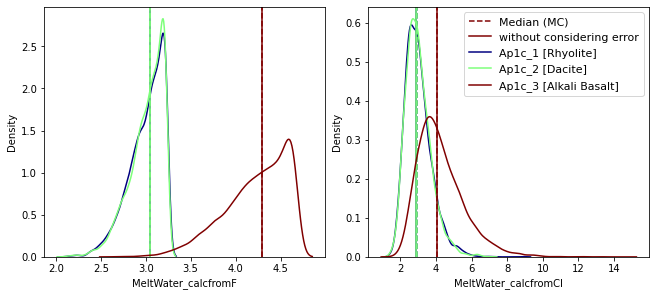

In [16]:
## set up color palette 
from mycolorpy import colorlist as mcp
colors=mcp.gen_color(cmap='jet',n=len(df_comb))

fig, axes = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True)

for i in range(len(df_comb)):
    sample=df_comb['sample'][i]
    unc=results_mc[results_mc['sample']==sample]

    ## plot the median of MC results (considering uncertainty), and the value without considering uncertainty 
    axes[0].axvline(x=df_comb["MeltWater_Fmedian"][i], c= colors[i], ls='--')
    axes[0].axvline(x=df_comb["MeltWater_calcfromF"][i], c= colors[i], ls='-')
    axes[1].axvline(x=df_comb["MeltWater_Clmedian"][i],  c= colors[i], ls='--',label='Median (MC)')    
    axes[1].axvline(x=df_comb["MeltWater_calcfromCl"][i], c= colors[i], ls='-',label='without considering error')

    ## plot the distribution of MC results
    sns.kdeplot(unc['MeltWater_calcfromF'], c= colors[i],  ax = axes[0])
    sns.kdeplot(unc['MeltWater_calcfromCl'],c= colors[i], label=sample+' ['+df_comb['MeltComp'][i]+']', ax = axes[1])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),ncol=1,fontsize=11,loc='best')
plt.show()


## save results

In [17]:
df_all=pd.concat([df,df_comb],axis=1)
df_all=df_all.loc[:,~df_all.columns.duplicated()]
df_all=df_all.drop(columns=["MeltComp"])

In [18]:
df_all

,sample,XF,XCL,MELTF,MELTCL,MELTCOMP,"T,C",XF_SD,XCL_SD,MELTF_SD,...,T_SD,MeltWater_calcfromF,MeltWater_calcfromCl,Model_used,MeltWater_Fmean,MeltWater_Fmedian,MeltWater_F1sd,MeltWater_Clmean,MeltWater_Clmedian,MeltWater_Cl1sd
0,Ap1c_1,0.400665,0.17206,600,2500,Rhyolite,950,0.01,0.01,100,...,20,3.043514,2.890552,rhyolite,3.003497,3.046976,0.195208,3.011100,2.904564,0.690114
1,Ap1c_2,0.400665,0.17206,600,2500,Dacite,950,0.01,0.01,100,...,20,3.047603,2.894301,dacite,3.007479,3.050916,0.190087,3.010041,2.908116,0.672337
2,Ap1c_3,0.400665,0.17206,600,2500,Alkali Basalt,950,0.01,0.01,100,...,20,4.296288,4.035510,alkali basalt,4.227564,4.292241,0.366478,4.274336,4.029978,1.213357


In [19]:
df_all.to_csv("outputs_melt_water_error.csv")